In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['../'])

Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0] on linux


In [2]:
import numpy as np
from scripts.data_utils import load_data, get_random_split, augment_data, get_multiple_splits
from scripts.augmentation_models import augmentaion_noise_jittering

from scripts.classification_models import LogRegPCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path_to_open  = '/data/Projects/OpenCloseIHB/opened_ihb.npy'
path_to_close = '/data/Projects/OpenCloseIHB/closed_ihb.npy'

# единичный сплит
X, y, groups = load_data(path_to_open, path_to_close)
X_train, X_test, y_train, y_test, train_groups, test_groups = get_random_split(X, y,groups, test_size=0.15)

Accuracy on train: 1.0
Accuracy on test: 0.885


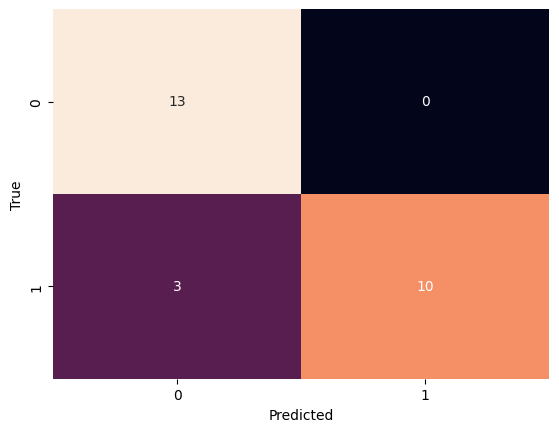

In [4]:
# обучение на одном сплите

logreg = LogRegPCA()
logreg.model.set_params(**{'C': 0.002})
logreg.pca.set_params(**{'n_components': 0.95})

train_acc = logreg.model_training(X_train, y_train)
conf_mat, acc = logreg.model_testing(X_test, y_test)

sns.heatmap(conf_mat, annot=conf_mat, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True');

In [4]:
# аугментация шумом
X_aug, y_aug, groups_aug, is_real_data = augment_data(augmentaion_noise_jittering, 
                                                      X, y, groups, n_aug=1)


# сплит данных по разным сидам
random_seeds = [42, 123, 456]

# аугментированные + реальные
splits_with_seeds_aug = get_multiple_splits(X_aug, y_aug, groups_aug, 
                                            is_real_data, test_size=0.2, 
                                            random_seeds=random_seeds)

# реальные
splits_with_seeds = get_multiple_splits(X, y, groups, 
                                        None, test_size=0.2, 
                                        random_seeds=random_seeds)

In [ ]:
# для каждого сплита обучаем модель 5 раз

folds = 5
logreg_metrics_real = np.zeros((len(random_seeds), folds))

for en, (X_train, X_test, y_train, y_test, train_groups, test_groups) in enumerate(splits_with_seeds):
    print(f'------ Seed: {random_seeds[en]} ------')

    for fold in range(folds):
        print(f'Fold: {fold}')
        
        logreg = LogRegPCA()
        train_acc = logreg.model_training(X_train, y_train)
        logreg_metrics_real[en, fold] = logreg.model_testing(X_test, y_test)[1]


In [ ]:
folds = 5
logreg_metrics_aug = np.zeros((len(random_seeds), folds))

for en, (X_train, X_test, y_train, y_test, train_groups, test_groups) in enumerate(splits_with_seeds_aug):
    print(f'------ Seed: {random_seeds[en]} ------')
    for fold in range(folds):
        print(f'Fold: {fold}')
        logreg = LogRegPCA()
        train_acc = logreg.model_training(X_train, y_train)
        logreg_metrics_aug[en, fold] = logreg.model_testing(X_test, y_test)[1]


In [ ]:
# без PCA 

folds = 5
logreg_metrics_no_pca = np.zeros((len(random_seeds), folds))

for en, (X_train, X_test, y_train, y_test, train_groups, test_groups) in enumerate(splits_with_seeds):
    print(f'------ Seed: {random_seeds[en]} ------')

    for fold in range(folds):
        print(f'Fold: {fold}')
        
        logreg = LogRegPCA(pca=False)
        train_acc = logreg.model_training(X_train, y_train)
        logreg_metrics_no_pca[en, fold] = logreg.model_testing(X_test, y_test)[1]


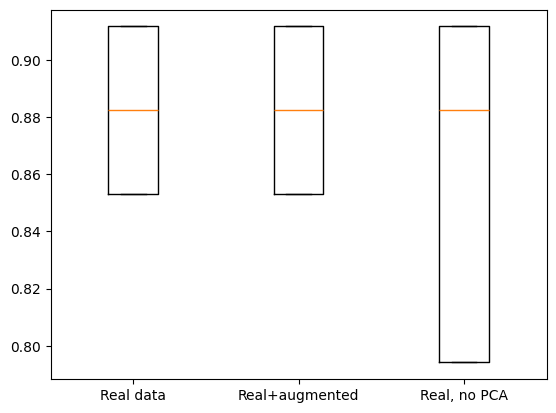

In [11]:
plt.boxplot([logreg_metrics_real.flatten(), 
             logreg_metrics_aug.flatten(),
             logreg_metrics_no_pca.flatten()],
            tick_labels=['Real data', 'Real+augmented', 'Real, no PCA']);